# Predicting Planetary Orbital Periods Using Linear Regression


This Jupyter Notebook aims to build and utilize a Linear Regression model to predict the orbital period of planets using the Planets dataset from Seaborn. The dataset includes several features of planets discovered by various methods over the years. Understanding orbital periods is crucial for astronomical studies and can aid in further research about planetary systems.
    


## Importing Advanced Libraries
In this section, we import essential libraries for data manipulation, visualization, machine learning modeling, and evaluation. Libraries like Pandas and Seaborn are used for data handling and visualization, while Scikit-Learn is utilized for its powerful machine learning tools and metrics.
                

In [1]:
%%capture
!pip install -U scikit-learn

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedShuffleSplit
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from ipywidgets import interact, interactive, fixed, interact_manual, Layout, Box, VBox
import ipywidgets as widgets


## Advanced Data Loading
Here, we load the 'planets' dataset using Seaborn. We perform an initial inspection of the data, including checking the first few rows, data types, missing values, and a statistical summary. This step is crucial for understanding the structure and quality of our data.
                

First Five Rows:
            method  number  orbital_period   mass  distance  year
0  Radial Velocity       1         269.300   7.10     77.40  2006
1  Radial Velocity       1         874.774   2.21     56.95  2008
2  Radial Velocity       1         763.000   2.60     19.84  2011
3  Radial Velocity       1         326.030  19.40    110.62  2007
4  Radial Velocity       1         516.220  10.50    119.47  2009

Data Types:
method             object
number              int64
orbital_period    float64
mass              float64
distance          float64
year                int64
dtype: object

Missing Values:
method              0
number              0
orbital_period     43
mass              522
distance          227
year                0
dtype: int64

Statistical Summary:
            number  orbital_period        mass     distance         year
count  1035.000000      992.000000  513.000000   808.000000  1035.000000
mean      1.785507     2002.917596    2.638161   264.069282  2009.070531
s

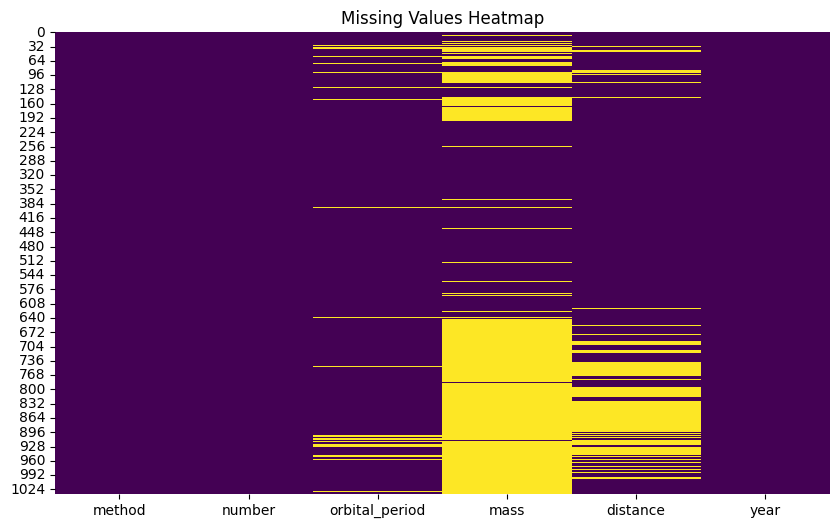

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
planets = sns.load_dataset('planets')

# Advanced Data Inspection
print("First Five Rows:")
print(planets.head())
print("\nData Types:")
print(planets.dtypes)
print("\nMissing Values:")
print(planets.isnull().sum())
print("\nStatistical Summary:")
print(planets.describe())

# Enhanced Visualization
plt.figure(figsize=(10, 6))
sns.heatmap(planets.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')

# Save the plot
plt.savefig('missing_values_heatmap.png')

plt.show()


## Sophisticated Data Preprocessing and Feature Engineering
This section covers advanced preprocessing steps such as handling missing values through imputation, defining categorical and numerical columns, and applying transformations using pipelines. We also conduct a correlation analysis to understand the relationships between different features.
                

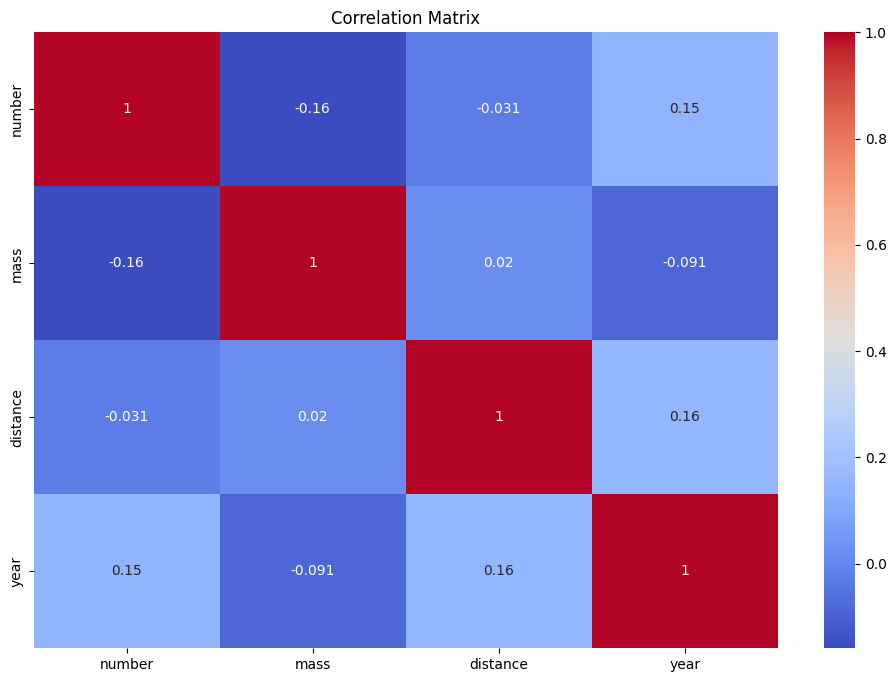

<Figure size 640x480 with 0 Axes>

In [49]:
# Load the dataset
planets = sns.load_dataset('planets')

# Handling missing values
# Impute missing values only for numerical columns
numerical_cols = [col for col in planets.columns if planets[col].dtype != 'object']
for col in numerical_cols:
    if planets[col].isnull().any():
        planets[col].fillna(planets[col].mean(), inplace=True)

# Additionally, handle missing values in the target variable 'orbital_period'
planets = planets.dropna(subset=['orbital_period'])

# Handle missing values in the 'method' column if needed
planets = planets.dropna(subset=['method'])

# Update the definition of categorical and numerical columns after handling missing values
categorical_cols = ['method']
numerical_cols = [col for col in planets.columns if col not in categorical_cols + ['orbital_period']]

# Creating pipelines for numerical and categorical preprocessing
numerical_pipeline = make_pipeline(StandardScaler())
categorical_pipeline = make_pipeline(OneHotEncoder())

# Combining preprocessing steps into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_cols),
        ('cat', categorical_pipeline, categorical_cols)
    ])

# Separating features and target variable
X = planets.drop('orbital_period', axis=1)
y = planets['orbital_period']

# Data Exploration: Correlation Analysis
# Compute correlation matrix for numerical columns only
numerical_data = planets[numerical_cols]
plt.figure(figsize=(12, 8))
sns.heatmap(numerical_data.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()
# Save the plot
plt.savefig('CORR_matrix.png')

plt.show()


## Stratified Data Splitting
To ensure our training and testing sets are representative of the overall dataset, we use stratified sampling based on a key categorical feature. This approach helps in maintaining the distribution of categories in both training and testing sets.
                

In [44]:
from sklearn.model_selection import StratifiedShuffleSplit
import seaborn as sns

# Load the dataset
planets = sns.load_dataset('planets')

# First, handle missing values in both 'method' and 'orbital_period' columns
# Drop rows where 'method' is NaN as they cannot be stratified
planets = planets.dropna(subset=['method'])

# Also, drop rows where 'orbital_period' (target variable) is NaN
planets = planets.dropna(subset=['orbital_period'])

# Ensure each class in 'method' has at least 2 instances for stratification
method_counts = planets['method'].value_counts()
valid_methods = method_counts[method_counts >= 2].index
filtered_planets = planets[planets['method'].isin(valid_methods)]

# Verify if the filtering is successful
if filtered_planets['method'].value_counts().min() < 2:
    raise ValueError("There is still a class with fewer than 2 instances.")

# Apply StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(filtered_planets, filtered_planets['method']):
    strat_train_set = filtered_planets.iloc[train_index]
    strat_test_set = filtered_planets.iloc[test_index]

# Now, strat_train_set and strat_test_set can be used for further analysis


## Applying Transformations to Stratified Data
After stratifying the data, we apply the preprocessing transformations to the train and test sets. This step involves scaling numerical features and encoding categorical features, preparing the data for effective machine learning modeling.
                

In [45]:
# Applying the transformations to the stratified data

# Check if the preprocessor is defined and is a ColumnTransformer
if not isinstance(preprocessor, ColumnTransformer):
    raise ValueError("Preprocessor is either not defined or not a ColumnTransformer")

# Separate features and target variable for the training set
X_train_strat = strat_train_set.drop('orbital_period', axis=1)
y_train_strat = strat_train_set['orbital_period']

# Separate features and target variable for the test set
X_test_strat = strat_test_set.drop('orbital_period', axis=1)
y_test_strat = strat_test_set['orbital_period']

# Apply the preprocessing transformations
# Transform the training data using the preprocessor
X_train_transformed = preprocessor.fit_transform(X_train_strat)

# Transform the test data using the already fitted preprocessor
X_test_transformed = preprocessor.transform(X_test_strat)

# The transformed datasets are now ready for model training and evaluation


## Model Initialization with Hyperparameter Tuning
In this part, we initialize a Ridge Regression model and use GridSearchCV for hyperparameter tuning. The process involves searching for the best model parameters to improve prediction accuracy, followed by training the model with the optimal parameters.
                

Best Hyperparameters: {'alpha': 10}


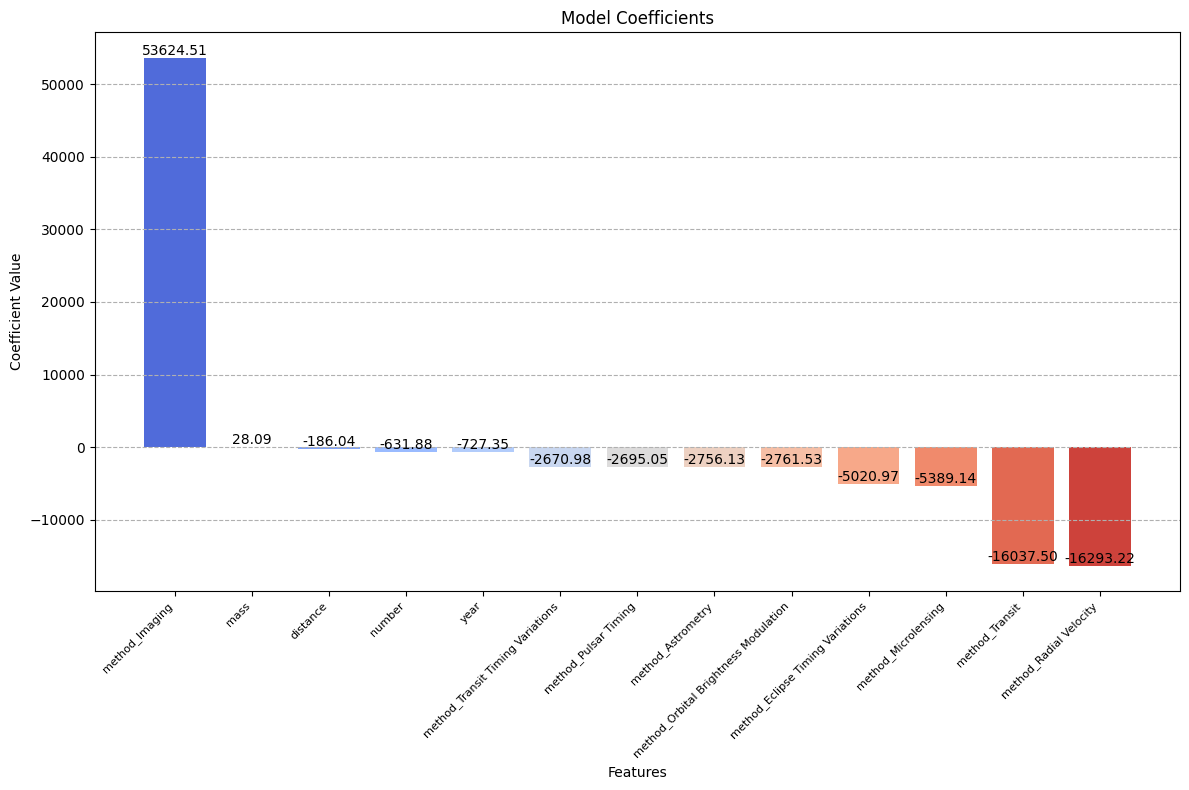

<Figure size 640x480 with 0 Axes>

In [50]:
# Load the dataset
planets = sns.load_dataset('planets')

# Handling missing values in both 'method' and 'orbital_period' columns
planets = planets.dropna(subset=['method', 'orbital_period'])

# Define categorical and numerical columns excluding the target 'orbital_period'
categorical_cols = planets.select_dtypes(include=['object']).columns
numerical_cols = planets.select_dtypes(exclude=['object']).columns.drop('orbital_period')

# Creating pipelines for numerical and categorical preprocessing
numerical_pipeline = make_pipeline(SimpleImputer(strategy='mean'), StandardScaler())
categorical_pipeline = make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder())

# Combining preprocessing steps into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_cols),
        ('cat', categorical_pipeline, categorical_cols)
    ])

# Ensure each class in 'method' has at least 2 instances
method_counts = planets['method'].value_counts()
valid_methods = method_counts[method_counts >= 2].index
filtered_planets = planets[planets['method'].isin(valid_methods)]

# Applying StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(filtered_planets, filtered_planets['method']):
    strat_train_set = filtered_planets.iloc[train_index]
    strat_test_set = filtered_planets.iloc[test_index]

# Preprocessing the data
X_train = strat_train_set.drop('orbital_period', axis=1)
y_train = strat_train_set['orbital_period']
X_test = strat_test_set.drop('orbital_period', axis=1)
y_test = strat_test_set['orbital_period']

# Transforming the data
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Initialize the Ridge Regression model with hyperparameter tuning
ridge_reg = Ridge()
param_grid = {'alpha': [0.1, 1, 10, 100]}

# Using GridSearchCV for finding the best hyperparameters
grid_search = GridSearchCV(ridge_reg, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)

# Train the model with the best hyperparameters
grid_search.fit(X_train_transformed, y_train)

# Display the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_

# Get feature names after one-hot encoding
categorical_encoder = preprocessor.named_transformers_['cat'].named_steps['onehotencoder']
feature_names = categorical_encoder.get_feature_names_out(categorical_cols)

# Concatenate numerical and categorical feature names
all_feature_names = np.concatenate((numerical_cols, feature_names))

# Visualizing model coefficients
coef_values = best_model.coef_
sorted_indices = np.argsort(coef_values)[::-1]  # Sort indices in descending order of coefficient values

plt.figure(figsize=(12, 8))
plt.bar(range(len(coef_values)), coef_values[sorted_indices], color=sns.color_palette("coolwarm", len(coef_values)))
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.title('Model Coefficients')

# Print coefficient values on the plot
for i in range(len(coef_values)):
    plt.text(i, coef_values[sorted_indices[i]], f"{coef_values[sorted_indices[i]]:.2f}", ha='center', va='bottom')

# Customize x-axis ticks and labels
plt.xticks(range(len(coef_values)), all_feature_names[sorted_indices], rotation=45, ha='right', fontsize=8)

# Add horizontal grid lines for better visualization
plt.grid(axis='y', linestyle='--')

plt.tight_layout()
plt.show()
# Save the plot
plt.savefig('coef_model.png')

plt.show()


## Comprehensive Model Evaluation and Inference
Here, we evaluate the model's performance on the test data using metrics like Mean Squared Error and R-squared. We also visualize the comparison between actual and predicted values to assess the model's accuracy. Lastly, we demonstrate how to make predictions with the trained model.
                

Best Hyperparameters: {'alpha': 10}


<Figure size 640x480 with 0 Axes>

Evaluation Metrics:
Mean Squared Error (MSE): 78494706.90
Root Mean Squared Error (RMSE): 8859.72
Mean Absolute Error (MAE): 2128.34
R-squared (R2): 0.46


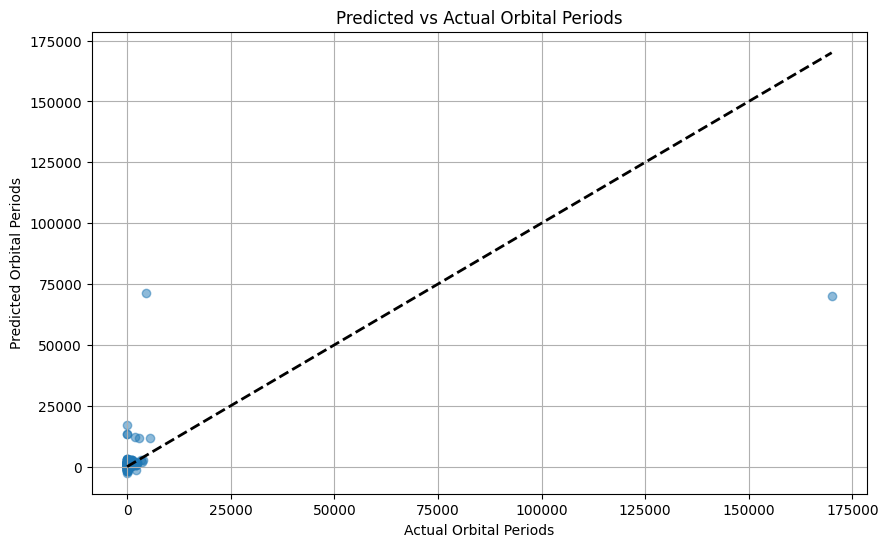

In [51]:
# Load the dataset
planets = sns.load_dataset('planets')

# Handling missing values in both 'method' and 'orbital_period' columns
planets = planets.dropna(subset=['method', 'orbital_period'])

# Define categorical and numerical columns excluding the target 'orbital_period'
categorical_cols = planets.select_dtypes(include=['object']).columns
numerical_cols = planets.select_dtypes(exclude=['object']).columns.drop('orbital_period')

# Creating pipelines for numerical and categorical preprocessing
numerical_pipeline = make_pipeline(SimpleImputer(strategy='mean'), StandardScaler())
categorical_pipeline = make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder())

# Combining preprocessing steps into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_cols),
        ('cat', categorical_pipeline, categorical_cols)
    ])

# Ensure each class in 'method' has at least 2 instances
method_counts = planets['method'].value_counts()
valid_methods = method_counts[method_counts >= 2].index
filtered_planets = planets[planets['method'].isin(valid_methods)]

# Applying StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(filtered_planets, filtered_planets['method']):
    strat_train_set = filtered_planets.iloc[train_index]
    strat_test_set = filtered_planets.iloc[test_index]

# Preprocessing the data
X_train = strat_train_set.drop('orbital_period', axis=1)
y_train = strat_train_set['orbital_period']
X_test = strat_test_set.drop('orbital_period', axis=1)
y_test = strat_test_set['orbital_period']

# Transforming the data
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Initialize the Ridge Regression model with hyperparameter tuning
ridge_reg = Ridge()
param_grid = {'alpha': [0.1, 1, 10, 100]}

# Using GridSearchCV for finding the best hyperparameters
grid_search = GridSearchCV(ridge_reg, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)

# Train the model with the best hyperparameters
grid_search.fit(X_train_transformed, y_train)

# Display the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_

# Define a function to calculate and display evaluation metrics
def display_evaluation_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print("Evaluation Metrics:")
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"R-squared (R2): {r2:.2f}")

# Define a function to plot predicted vs actual values
def plot_predicted_vs_actual(y_true, y_pred):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=2)
    plt.xlabel('Actual Orbital Periods')
    plt.ylabel('Predicted Orbital Periods')
    plt.title('Predicted vs Actual Orbital Periods')
    plt.grid(True)
    plt.show()
    # Save the plot
plt.savefig('PvA.png')

plt.show()

# Define a function to predict the orbital period based on user input
def predict_orbital_period(method, number, mass, distance, year):
    new_planet_data = {
        'method': [method],
        'number': [number],
        'mass': [mass],
        'distance': [distance],
        'year': [year]
    }
    new_planet_df = pd.DataFrame(new_planet_data)

    # Transform the new data using the preprocessor and predict using the trained model
    new_planet_transformed = preprocessor.transform(new_planet_df)
    predicted_orbital_period = best_model.predict(new_planet_transformed)
    print(f"Predicted Orbital Period for a new planet: {max(predicted_orbital_period[0], 0):.2f} days")

# Get the range of years from your dataset
min_year = filtered_planets['year'].min()
max_year = filtered_planets['year'].max()

# Create interactive widgets for user input with relevant year range
method_widget = widgets.Dropdown(options=filtered_planets['method'].unique(), description='Method:', layout=Layout(width='auto'))
number_widget = widgets.FloatSlider(min=0, max=10, value=1, description='Number:', layout=Layout(width='auto'))
mass_widget = widgets.FloatSlider(min=0, max=20, value=5.5, description='Mass:', layout=Layout(width='auto'))
distance_widget = widgets.FloatSlider(min=0, max=100, value=50, description='Distance:', layout=Layout(width='auto'))
year_widget = widgets.IntSlider(min=min_year, max=max_year, value=min_year, description='Year:', layout=Layout(width='auto'))

# Create interactive output widget to display predictions
output = widgets.interactive_output(predict_orbital_period, {'method': method_widget, 'number': number_widget,
                                                             'mass': mass_widget, 'distance': distance_widget,
                                                             'year': year_widget})

# Display evaluation metrics and plot
predictions = best_model.predict(X_test_transformed)
display_evaluation_metrics(y_test, predictions)
plot_predicted_vs_actual(y_test, predictions)

# Create labels for widgets
labels = ['Select Method:', 'Number of Planets:', 'Mass (Earth Masses):', 'Distance (Light Years):', 'Year:']

# Create layout for widgets
inputs = VBox([Box(children=[widgets.Label(value=label, layout=Layout(width='150px')), widget])
               for label, widget in zip(labels, [method_widget, number_widget, mass_widget, distance_widget, year_widget])])

# Display widgets and output in a VBox layout
display(VBox([inputs, output]))


This notebook provides a comprehensive workflow from data (structured and unstructured sets of information) loading, preprocessing, model training, and inference, aimed at predicting orbital periods of planets.
    